In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#to import data from drive
from google.colab import drive
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.callbacks import EarlyStopping
#to display images and graphs
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
#connecting to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#path to the data
data_directory = '/content/drive/MyDrive/MiniProject'

In [4]:
# Define the image dimensions
img_width, img_height = 128, 128

# Define the number of classes
num_classes = 2

In [5]:
# Load the images and their labels
def load_data(folder):
    images = []
    labels = []
    classes = os.listdir(folder)
    for class_name in classes:
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            class_label = class_name
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                if os.path.isfile(image_path):
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (img_width, img_height))
                    images.append(image)
                    labels.append(class_label)
    return np.array(images), np.array(labels)

In [6]:
# Load the data
images, labels = load_data(data_directory)

In [7]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

# Split the training set further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [8]:
# Normalize pixel values to the range of [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

In [9]:
# Convert the labels to one-hot encoding
y_train = tf.one_hot(y_train, num_classes)
y_test = tf.one_hot(y_test, num_classes)
y_val = tf.one_hot(y_val, num_classes)

In [10]:
# Create the CNN model
model = Sequential()

In [11]:
model.add(Conv2D(16, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='sigmoid'))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [14]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_val, y_val), callbacks=reduce_lr)

Epoch 1/50
298/298 [==============================] - 15s 12ms/step - loss: 0.7135 - accuracy: 0.6076 - val_loss: 0.6894 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 2/50
298/298 [==============================] - 2s 8ms/step - loss: 0.6285 - accuracy: 0.6278 - val_loss: 0.6048 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/50
298/298 [==============================] - 2s 8ms/step - loss: 0.5815 - accuracy: 0.6798 - val_loss: 0.5766 - val_accuracy: 0.6972 - lr: 0.0010
Epoch 4/50
298/298 [==============================] - 3s 10ms/step - loss: 0.5259 - accuracy: 0.7124 - val_loss: 0.6004 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 5/50
298/298 [==============================] - 3s 9ms/step - loss: 0.4848 - accuracy: 0.7498 - val_loss: 0.5250 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 6/50
298/298 [==============================] - 2s 8ms/step - loss: 0.4325 - accuracy: 0.7831 - val_loss: 0.5546 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 7/50
298/298 [==============================] - 2s 8ms/step -

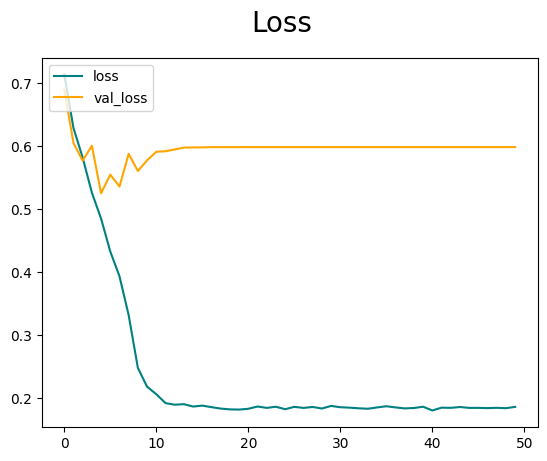

In [15]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

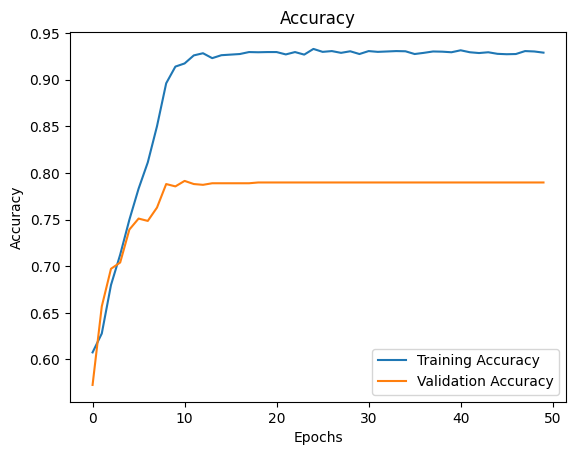

In [16]:

# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [17]:
# Test the data using the trained model
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)  # Convert true labels to class labels

47/47 [==============================] - 1s 9ms/step


In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

47/47 [==============================] - 0s 7ms/step - loss: 0.6018 - accuracy: 0.7948
Test loss: 0.601753294467926
Test accuracy: 0.794750988483429


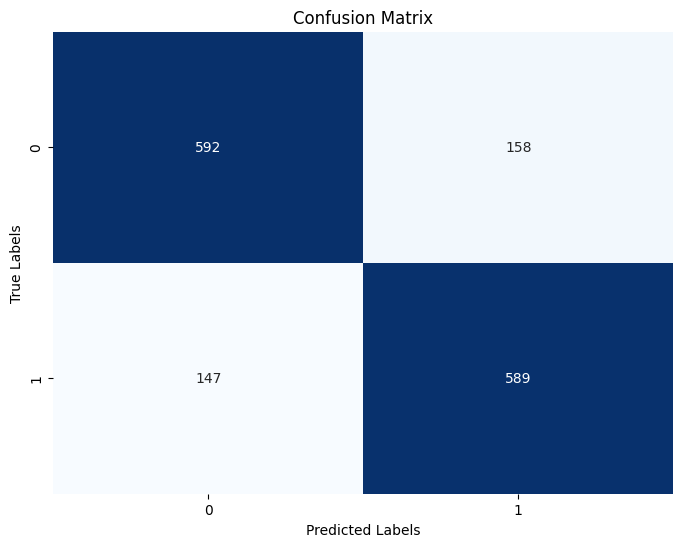

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Print the classification report
report = classification_report(y_true_labels, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       750
           1       0.79      0.80      0.79       736

    accuracy                           0.79      1486
   macro avg       0.79      0.79      0.79      1486
weighted avg       0.79      0.79      0.79      1486



In [21]:
# Save the trained model
model.save('RecycleNet3.0.h5')